<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Linear Regression

_Authors: Kevin Markham (Washington, D.C.), Ed Podojil (New York City)_

#### Learning Objectives
- Define "data modeling" and "simple linear regression."
- Build a linear regression model using a data set that meets the linearity assumption using the scikit-learn library.
- Understand and identify multicollinearity in a multiple regression.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")

<a id="introduce-the-bikeshare-dataset"></a>
## Bikeshare Data Set
---

We are going to use bikeshare data to build a simple demand forecasting model.

**Possible applications:**

* Find where to site new bikeshare stations and know how large of a station to build.
* Calculate the expected wear and tear on bikes and what the replacement costs will be.
* Use a slightly different research design to forecast full and empty stations and send a service vehicle to "rebalance" the bikes from one station to another, as sometimes bikeshare stations have no bikes or are completely full and prevent use of the station.

In [2]:
# Read the data and set the datetime as the index.
path = './data/bikeshare.csv'
bikes = pd.read_csv(path, index_col='datetime', parse_dates=True)

In [3]:
# Preview the first five rows of the DataFrame.
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,3.28,3.0014,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,2.34,1.9982,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,2.34,1.9982,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,3.28,3.0014,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,3.28,3.0014,75,0.0,0,1,1


Each observation is an hour of events.

`count` indicates the total number of riders. It will be the target variable that we try to forecast.

`causal` and `registered` are segments of the total users, so they are alternative target variables  that aren't available for forecasting total users.

#### Data dictionary

| Variable| Description |
|---------|----------------|
|datetime| hourly date + timestamp  |
|season|  1 = spring, 2 = summer, 3 = fall, 4 = winter |
|holiday| whether the day is considered a holiday|
|workingday| whether the day is neither a weekend nor holiday|
|weather| See below|
|temp| temp_celsius in Celsius|
|atemp| "feels like" temp_celsius in Celsius|
|humidity| relative humidity|
|windspeed| wind speed|
|casual| number of non-num_registered_users user rentals initiated|
|registered| number of num_registered_users user rentals initiated|
|count| number of total rentals|

_Details on Weather Variable_:

- **1**: Clear, Few clouds, Partly cloudy, Partly cloudy
- **2**: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- **3**: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- **4**: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

#### Exercise:

- Rename the columns in `bikes` as indicated below.

| old name | new name |
| ---    | --- |
| temp | temp_celsius
| windspeed | windspeed_knots
| casual | num_casual_users
| registered | num_registered_users
| season | season_num
| holiday | is_holiday
| workingday | is_workingday
| humidity | humidity_percent
| count | num_total_users

Using these more explicit names will make it easier to avoid mistakes.

In [4]:
bikes.rename(columns = {'temp':'temp_celsius',
                      'atemp':'atemp_celsius',
                      'windspeed': 'windspeed_knots',
                      'casual': 'num_casual_users',
                      'registered': 'num_registered_users',
                      'season': 'season_num',
                      'holiday': 'is_holiday',
                      'workingday': 'is_workingday',
                      'humidity': 'humidity_percent',
                      'count': 'num_total_users'
                      }, inplace=True)

In [5]:
bikes.head()

,season_num,is_holiday,is_workingday,weather,temp_celsius,atemp_celsius,humidity_percent,windspeed_knots,num_casual_users,num_registered_users,num_total_users
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,3.28,3.0014,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,2.34,1.9982,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,2.34,1.9982,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,3.28,3.0014,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,3.28,3.0014,75,0.0,0,1,1


<a id="visualizing-the-data"></a>
## Our First Model

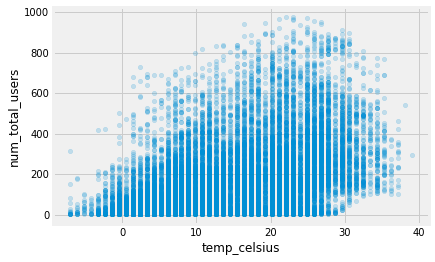

In [6]:
# make a scatterplot of `num_total_users` against `temp_celsius`
fig, ax = plt.subplots()
bikes.plot(kind='scatter', x='temp_celsius', y='num_total_users', alpha=0.2, ax=ax);

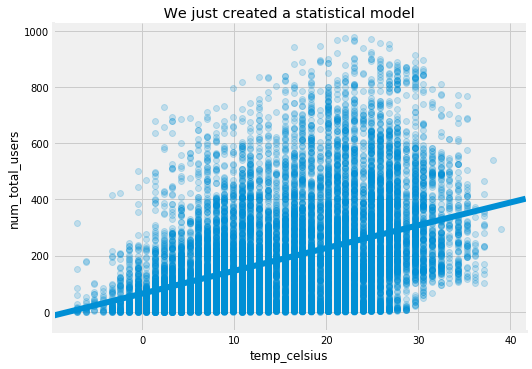

In [7]:
# Use Seaborn to create a scatterplot with regression line
# sns.lmplot does not allow us to pass in an Axes object.
# It creates a FacitGrid object that has the relevant Axes object
# as its ax attribute.
g = sns.lmplot(x='temp_celsius', 
               y='num_total_users',
               data=bikes,
               scatter_kws={'alpha': 0.2},
               aspect=1.5,
              )
ax = g.ax
ax.set_title(' We just created a statistical model ');


We just created a linear regression model!

- **Formula for a line:** $y = mx + b$
- **Alternative notation:** $y = \beta_0 + \beta_1 * x$
- **Our model:** $\mbox{num_total_users} = \beta_0 + \beta_1 * \mbox{temp_celsius} + \epsilon$

We call $\beta_0$ the **model intercept** and $\beta_1$ the **coefficient of `temp_celsius`**.

We call $\epsilon$ the **noise** or **error term**. It accounts for the fact that our points do not lie exactly on a line. Linear regression is designed to be optimal when this noise is normally distributed with constant variance. We ignore it when we use the model to make predictions.

**Exercise.** Answer each question below in terms of $\beta_0$ ("beta naught"), $\beta_1$, and $\epsilon$ ("epsilon").

- What would our model predict for `num_total_users` at `temp_celsius=0`?

$\beta_0$

- If `temp_celsius` increases by 5, how does our model's prediction for `num_total_users` change? What if $\beta_1$ were negative?

prediction has increased by 5 * $\beta_1$    
-- when the $\beta_1$ is negative then it will go down

- I claim that this model does *not* tell us how the number of total uses would change if we were (somehow) to intervene to increase $temp\_celsius$ by 5. Why not?

-- lets say temp is cause of number of users. Temp is nice and people will ride bike. But there are other causes, that we havent captured like is it work day.
-- The bigger issue here is there is a third variable which is a common cause of temp and users so temp may not be directly causing number of users. That variable can be seasons. Say a hot day in winter still less users, vs good day in summer where more users will be there.
-- Another can be time of the day variable. so time of day is causing the temp and its also causing the users, i.e. separately from temp causing users.

-- so when we talk about intevening we talk about causation. 

---

**Takeaways:**

- Linear regression with one input feature chooses the *line* that "best fits" a scatterplot of the target variable against that input feature.
- The model intercept tells you what the model would predict if all of the input variables were zero.
- The coefficient on a variable tells you how much and in what direction the model's prediction would change if the relevant variable were to increase by 1.

# Building a Linear Regression Models with scikit-learn

When we called `sns.lmplot`, `seaborn` created a linear regression model which it then displayed to us.

A more typical workflow for creating a linear regression model uses scikit-learn.

scikit-learn is the most popular Python library for machine learning.

**Strengths:**

- Includes good implementations of a wide range of algorithms.
- Provides consistent interface across model types.
- Provides excellent documentation.
- Large community --> tons of resources for learning and getting questions answered.

**Limitations:**

- Designed primarily for single-thread, in-memory computing.
- Has only basic capabilites for deep learning.
- Reflects machine learning rather than statistics mindset: focuses on predictive accuracy on held-out data rather than hypothesis testing, parameter estimation, and model interpretation.

In [8]:
# 1. Import the LinearRegression model class.
from sklearn.linear_model import LinearRegression

In [9]:
# 2. Make an instance of the LinearRegression class.
lr_celsius = LinearRegression()
type(lr_celsius)

sklearn.linear_model.base.LinearRegression

In [10]:
# 3. Train the model instance on our data.
# We will use just temp_celsius for now.
# Fitting changes the model `lr_celsius` in-place. scikit-learn is figuring out
# the values to use for $\beta_0$ and $\beta_1$ and storing them inside the model
# so that it can be used for prediction.
x = bikes.loc[:, ['temp_celsius']] # putting column name in square bracket so that I get back df
y = bikes.loc[:, 'num_total_users'] # here sklearn expect series, so not putting square brackets
lr_celsius.fit(x, y) # fit the model is training the model
# another reason by x is 2 dimensional / df, as there can be lots and lots of feature
# but what we are predicting is 1 dimensional thus y is one dimensional
# note fit changes the model in place


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
# 4. Use the model to make predictions.
# We will add the fitted values to our DataFrame.
lr_celsius.predict(x)

array([91.47518523, 83.84928678, 83.84928678, ..., 99.10108367,
       99.10108367, 99.10108367])

In [12]:
bikes.loc[:, 'predictions'] = lr_celsius.predict(x)

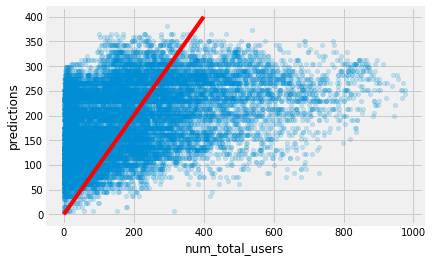

In [13]:
# Let's compare fitted values to actual.
fig, ax = plt.subplots()
bikes.plot(kind='scatter', x='num_total_users', y='predictions', ax=ax, alpha=0.2)
ax.plot([0, 400], [0, 400], 'r');

**Exercise.**

- What would the plot above look like if our model's predictions were perfectly accurate?

- What would we see if our model couldn't be perfectly accurate because `num_total_users` is affected by factors that are not perfectly correlated with `temp_celsius`, but we satisfied the conditions for linear regression to be optimal? Is that what we do see?

---

In [14]:
# Drop the fitted values from our DataFrame
bikes.drop('predictions', axis=1, inplace=True)

<a id="scikit-learns--step-modeling-pattern"></a>
### scikit-learn's Four-Step Modeling Pattern

1. Import the class you plan to use.
2. "Instantiate" the class. You can specify "hyperparameters" at this point.
3. Fit the model instance with data. (This step changes the model object in-place.)
4. Use the fitted model to make predictions.

# Linear Regression with Multiple Features

- **Using `temp_celsius` only:** $\mbox{num_total_users} = \beta_0 +  \beta_1 * \mbox{temp_celsius} + \epsilon$
- **Using `temp_celsius` and `humidity_percent`:** $\mbox{num_total_users} = \beta_0 +  \beta_1 * \mbox{temp_celsius} +  \beta_2 * \mbox{humidity_percent} + \epsilon$

Linear regression with two input features chooses the "plane" that "best fits" a 3D scatterplot of the target variable against those input features.

In general, linear regression chooses the "hyperplane" that "best fits" a scatterplot of the target variable against the input features.

**Exercise.** Answer each question below for the second model written out above, in terms of $\beta_0$, $\beta_1$, $\beta_2$, and $\epsilon$ ("epsilon").

- What would our model predict for `num_total_users` at `temp_celsius=0` and `humidity_percent=0`?

$\beta_0$

- If `temp_celsius` increases by 5 while `percent_humidity` remains the same, how does our model's prediction for `num_total_users` change?

increase by 5 * $\beta_1$

- If `percent_humidity` decreases by 3 while `temp_celsius` remains the same, how does our model's prediction for `num_total_users` change?

decrease by 3 * $\beta_2$

- Why does the previous question say "while `temp_celsius` remains the same?"

for same temperature with different humidity we are trying to predict

- What would it mean if a feature had a coefficient of 0?

then it has no weight then doesnt matters in the prediction of model

**Takeaways:** Interpretation of the parameters of a linear regression model does not change as we add more variables, except that each coefficient tells us how the model's prediction would change if the associated variable were to change *while all other variables remained the same*.

---

In [15]:
# 1. Import the model class - we already did that

In [16]:
# 2. Instantiate the class
lr_celsius_hum = LinearRegression()

In [17]:
# 3. fit the model
X = bikes.loc[:, ['temp_celsius', 'humidity_percent']] # capital letter X as its data frame return
y = bikes.loc[:, 'num_total_users']

lr_celsius_hum.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
lr_celsius_hum.predict(X)

array([ 45.58545501,  41.13293876,  41.13293876, ..., 111.22542002,
       122.3504107 ,  97.31918166])

In [19]:
print (lr_celsius_hum.intercept_)
print (lr_celsius_hum.coef_)

245.62529755774983
[ 7.69549353 -2.78124767]


### Exercise

Build another linear regression model, this time using all of our features as inputs instead of just `temp_celsius`.

**Model using all columns as given:** $\mbox{num_total_users} = \beta_0 + \beta_1 * \mbox{season_num} + \beta_2 * \mbox{is_holiday} + \beta_3 * \mbox{is_workingday} + \beta_4 * \mbox{weather} + \beta_5 * \mbox{temp_celsius} + \beta_6 * \mbox{atemp_celsius} + \beta_7 * \mbox{humidity_percent} + \beta_8 * \mbox{windspeed_knots} + \epsilon$

- Store a pandas DataFrame with the values of the feature variables (everything except `num_casual_users`, and `num_total_users`) as a Python variable X.

In [20]:
X = bikes.loc[:, ['season_num', 'is_holiday', 'is_workingday', 'weather', 'temp_celsius', 'atemp_celsius',
                 'humidity_percent', 'windspeed_knots']] # capital letter X as its data frame return
y = bikes.loc[:, 'num_total_users']



Run the cell below to check your work. (You do not have to understand how this code works -- just know that it will raise an error if your X or y has the wrong type or shape.)

In [21]:
# Tests
assert isinstance(y, pd.Series)
assert isinstance(X, pd.DataFrame)
assert y.shape == (bikes.shape[0],)
assert X.shape == (bikes.shape[0], 8)

- Make a new instance of the LinearRegression class. Call it lr_all to distinguish it from our last model.

In [22]:
lr_all = LinearRegression()

- Train the model instance using our new feature matrix $X$ and the same target variable $y$.

In [23]:
lr_all.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

- Store `lr_all`'s fitted values in a new `predictions` column of the `bikes` DataFrame.

In [24]:
bikes.loc[:, 'predictions'] = lr_all.predict(X)

In [25]:
bikes.head()

,season_num,is_holiday,is_workingday,weather,temp_celsius,atemp_celsius,humidity_percent,windspeed_knots,num_casual_users,num_registered_users,num_total_users,predictions
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,3.28,3.0014,81,0.0,3,13,16,15.929429
2011-01-01 01:00:00,1,0,0,1,2.34,1.9982,80,0.0,8,32,40,13.144246
2011-01-01 02:00:00,1,0,0,1,2.34,1.9982,80,0.0,5,27,32,13.144246
2011-01-01 03:00:00,1,0,0,1,3.28,3.0014,75,0.0,3,10,13,34.197206
2011-01-01 04:00:00,1,0,0,1,3.28,3.0014,75,0.0,0,1,1,34.197206


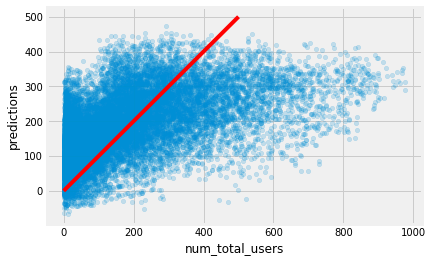

In [26]:
# Compare predicted values to actual
fig, ax = plt.subplots()
bikes.plot(kind='scatter', x='num_total_users', y='predictions', ax=ax, alpha=0.2)
ax.plot([0, 500], [0, 500], 'r');

The plot above shows how well the model fits the data it was trained on. How well it would predict new data that it wasn't trained on is a further issue.

In [27]:
# Drop the fitted values from our DataFrame
bikes.drop('predictions', axis=1, inplace=True)

---

#### Explore the intercept and coefficients of the linear model

In [28]:
# Print intercept and coefficients
print(lr_all.intercept_)
print(lr_all.coef_)

216.0993030302431
[ 19.80244456 -21.83281619   3.31021316   8.51301983   1.4708144
   4.43306071  -3.04462961  52.92027726]


In [29]:
# `zip` example
X.columns

Index(['season_num', 'is_holiday', 'is_workingday', 'weather', 'temp_celsius',
       'atemp_celsius', 'humidity_percent', 'windspeed_knots'],
      dtype='object')

In [30]:
# Use `zip` to get variable names next to coefficients
list(zip(X.columns, lr_all.coef_))

[('season_num', 19.80244455924721),
 ('is_holiday', -21.832816189342477),
 ('is_workingday', 3.3102131572972446),
 ('weather', 8.513019833477136),
 ('temp_celsius', 1.4708143995910972),
 ('atemp_celsius', 4.4330607149445225),
 ('humidity_percent', -3.0446296119068386),
 ('windspeed_knots', 52.92027726014757)]

**Exercise.** How do the model's predictions change for a holiday vs. a non-holiday, all else being equal?

They decrease by 21.8

---

In [31]:
# Look at the documentation for a LinearRegression model object


# A Little Theory

Fitting a linear regression selects the coefficients and intercept that minimize the **sum of squared errors** of the fitted values on the training set.

![Estimating coefficients](./assets/estimating_coefficients.png)

In the diagram above:

- The black dots are the **observed values** of x and y.
- The blue line is our **least squares line**.
- The red lines are the **residuals**, which are the vertical distances between the observed values and the least squares line.

**Justification:** Minimizing the sum of squared errors maximizes *the probability of the data given the model* (call the **likelihood** of the model on the data) on the assumption that the target variable really is a linear function of the features plus normally distributed noise: $y = \beta_0 + \sum \beta_i x_i + \epsilon$ where $\epsilon \sim \mathcal{N}(0, \sigma^2)$

![](./assets/400px-Linear_regression.svg.png)

<a id="overview-of-supervised-learning"></a>
## Overview of Supervised Learning
---

![Supervised learning diagram](./assets/supervised_learning.png)

<a id="does-the-scale-of-the-features-matter"></a>
### Does the Scale of the Features Matter?

Let's say that temp_celsius was measured in Fahrenheit, rather than Celsius. How would that affect our first model?

In [32]:
# Create a new column for Fahrenheit temp_celsius.


In [33]:
# Seaborn scatterplot with regression line


#### Rebuild the first model using temp_fahrenheit instead or temp_celsius.

In [34]:
# Create X and y.


In [35]:
# Instantiate and fit.


In [36]:
# Print the coefficients.


#### Convert 25 degrees Celsius to Fahrenheit.

In [37]:
25*1.8 + 32

77.0

In [38]:
# Predict rentals for 25 degree celsius


In [39]:
# Predict rentals for for 77 degrees Fahrenheit


**Conclusion:** The scale of the features is irrelevant for linear regression models. When changing the scale, we simply change our interpretation of the coefficients.

In [ ]:
# Remove the temp_fahrenheit column.


<a id="visualizing-the-data-part-"></a>
### Exploring the Data

Blindly throwing all of your variables into a linear regression model is not a great strategy. Let's inspect our data and come up with something smarter.

In [40]:
# Create feature column variables
feature_cols = ['temp_celsius', 'season_num', 'weather', 'humidity_percent']

#### Create a subset of scatterplot matrix using Seaborn.
We can use pairplot with the `y_vars` argument to only show relationships with the `num_total_users` variable

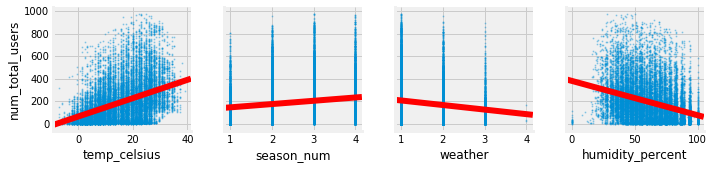

In [42]:
# Multiple scatterplots in Seaborn
g = sns.pairplot(bikes,
                 x_vars=feature_cols,
                 y_vars='num_total_users',
                 kind='reg',
                 plot_kws={'scatter_kws': {'s': 1, 'alpha': .3},
                          'line_kws': {'color': 'r'}
                          }
                );

**Exercise.**

/poll "Which is the best interpretation of the slope of the line for `num_total_users` against `humidity_percent`?" "How much a linear regression model's predictions for `num_total_users` against `humidity_percent` would change given a one-unit change in `humidity_percent`" "How much a linear regression model's predictions for `num_total_users` against `temp_celsius`, `season_num`, `weather`, and `humidity_percent` would change given a one-unit change in `humidity_percent`" "How much a linear regression model's predictions for `num_total_users` against `temp_celsius`, `season_num`, `weather`, and `humidity_percent` would change given a one-unit change in `humidity_percent`, holding all of those other variables constant"

#### Explore the season_num variable using a cross-tab.

In [43]:
# Cross-tabulation of season_num and month
pd.crosstab(bikes.loc[:, 'season_num'], bikes.index.month)

col_0,1,2,3,4,5,6,7,8,9,10,11,12
season_num,,,,,,,,,,,,
1,1429,1341,949,0,0,0,0,0,0,0,0,523
2,0,0,524,1437,1488,960,0,0,0,0,0,0
3,0,0,0,0,0,480,1488,1475,1053,0,0,0
4,0,0,0,0,0,0,0,0,384,1451,1437,960


#### Explore the season_num variable using a box plot.

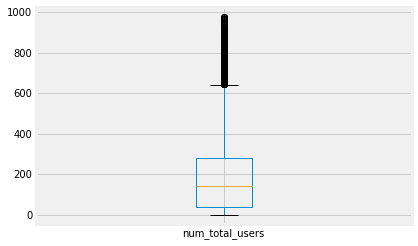

In [44]:
# Box plot of rentals, grouped by season_num.
fig, ax = plt.subplots()
bikes.loc[:, 'num_total_users'].plot()

#### Look at rentals over time.

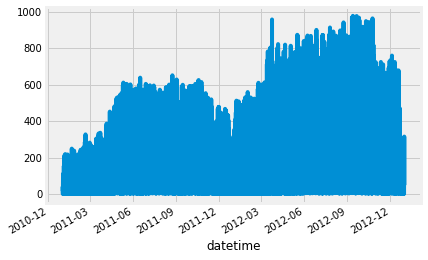

In [45]:
# Line plot of rentals
fig, ax = plt.subplots()
bikes.loc[:, 'num_total_users'].plot()

- **Trend:** System is generally growing over time.
- **Seasonality:** Periodic patterns in the data:
    - Yearly
    - Weekly
    - Daily

A good model will account for both.

#### Look at the correlation matrix

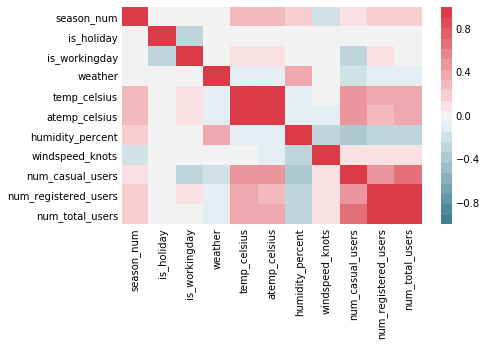

In [49]:
# Visualize correlation matrix in Seaborn using a heat map.
sns.heatmap(bikes.corr(),
            vmin=-1,
            vmax=1,
            cmap=sns.diverging_palette(220, 10, n=21),
            
           )

**Exercise.**

- We have two pairs of variables that are extremely strongly correlated. Which are they?

- Which features are positively correlated with `num_total_users` (leaving aside `num_casual users` and `num_registered_users`)?

- Which features are negatively correlated with `num_total_users` (leaving aside `num_casual users` and `num_registered_users`)?

- Which features show very little correlation with `num_total_users` (leaving aside `num_casual users` and `num_registered_users`)?

<a id="adding-more-features-to-the-model"></a>
### Adding More Features to the Model

We want features that are strongly correlated with the target and not with each other.

**Exercise.**

- Create another `LinearRegression` instance that is fit using `temp_celsius` and `atemp_celsius`, and print the coefficients.

In [50]:
X = bikes.loc[:, ['temp_celsius', 'atemp_celsius']]
y = bikes.loc[:, 'num_total_users']
lr_temp_atemp = LinearRegression()

lr_temp_atemp.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [54]:
list(zip(X.columns, lr_temp_atemp.coef_))

[('temp_celsius', 7.186045916463201), ('atemp_celsius', 0.748593908995792)]

- Create another `LinearRegression` instance that is fit using `atemp_celsius` only, and print the coefficients.

In [55]:
X = bikes.loc[:, ['atemp_celsius']]
y = bikes.loc[:, 'num_total_users']
lr_atemp = LinearRegression()

lr_atemp.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [56]:
list(zip(X.columns, lr_atemp.coef_))

[('atemp_celsius', 6.411820794076331)]

- Why is the coefficient for `atemp_celsius` so different in the two models?

The idea is when you have multiple variables in Linear regression, you can't just say oh atemp is small impact. See when we did that individually it had lot of impact. In other words when features are taken together then model one variable effect is with other being constant


<a id="what-is-multicollinearity"></a>
## What Is Colinearity?
---

Colinearity happens when two or more features are highly correlated with each other. It causes problems:

- Coefficients become hard to interpret
- Adding a variable to the model that is colinear with another variable in the model adds complexity while contributing limited new information, which can lead to overfitting.
- Model fitting can become numerically unstable.

## How to Select a Model

#### Recall: Model Bias and Variance

In [57]:
# You do not need to understand how this code works, just that it creates a LOT of features
from sklearn.preprocessing import PolynomialFeatures

X = (bikes.iloc[:2000, :]
     .loc[:, ['season_num',
              'is_holiday',
              'is_workingday',
              'weather',
              'temp_celsius',
              'atemp_celsius',
              'humidity_percent',
              'windspeed_knots']]
              )
pf = PolynomialFeatures(degree=6)
X = pf.fit_transform(X)
print(X.shape)

(2000, 3003)


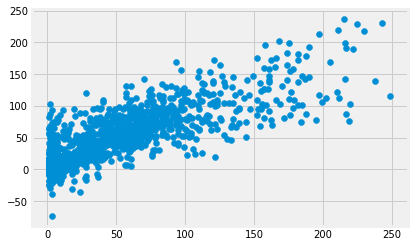

In [59]:
# Fit a model on the first 1000 rows and look at the fit
lr_poly = LinearRegression()
lr_poly.fit(X[:1000, :], y.iloc[:1000])

fig, ax = plt.subplots()
ax.scatter(y.iloc[:1000], lr_poly.predict(X[:1000, :]))

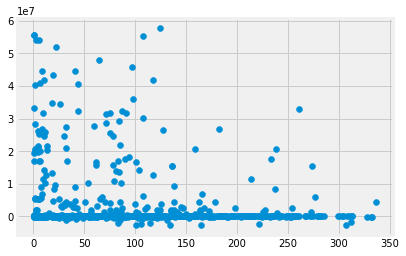

In [60]:
# See how the model does on the next 1000 rows
fig, ax = plt.subplots()
ax.scatter(y.iloc[1000:2000], lr_poly.predict(X[1000:2000, :]))

**Moral 1:** Models that are too complicated for the sample size will fit the training data well but generalize poorly; this phenomenon is called **overfitting**.

**Exercise.**

- Does this overly complicated model have more of a bias problem or more of a variance problem?

**Moral 2:** If our primary concern is how well our model generalizes to new data, then we can evaluate it by seeing how it does on data that we hold out from the training set.

**Notes:**

- If you have a stats background then you might be used to using p-values to decide what variables to keep, or perhaps specialized model selection criteria such as adjusted R-squared, AIC, or BIC. But if what you really care about is predictive accuracy on data that the model hasn't seen before, then using a holdout set is a more direct approach.
- In a business context, you may sacrifice some predictive accuracy by using fewer input features for the sake of computational performance, maintainability, and interpretability.

<a id="evaluation-metrics-for-regression-problems"></a>
### Evaluation Metrics for Regression Problems

**Mean absolute error (MAE)** is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean squared error (MSE)** is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root mean squared error (RMSE)** is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

**Exercise.** Calculate MAE, MSE, and RMSE for the values below.

In [61]:
# Example true and predicted response values
true = [10, 7, 5, 5]
pred = [8, 6, 5, 10]

In [70]:
# Fill in these calculations. Hint: Turn the lists in numpy arrays.

true = np.array(true)
pred = np.array(pred)

print (true)
print (pred)



mae = sum(abs(true-pred))/len(true)
mse = sum((true-pred)**2)/len(true)
rmse = np.sqrt(mse)

print (mae)
print (mse)
print (rmse)







[10  7  5  5]
[ 8  6  5 10]
2.0
7.5
2.7386127875258306


In [71]:
# Run this cell to check your answers.

from sklearn import metrics
print(mae)
print(mse)
print(rmse)
np.testing.assert_almost_equal(mae, metrics.mean_absolute_error(true, pred))
np.testing.assert_almost_equal(mse, metrics.mean_squared_error(true, pred))
np.testing.assert_almost_equal(rmse, np.sqrt(metrics.mean_squared_error(true, pred)))

2.0
7.5
2.7386127875258306


In [ ]:
# Compare:


Let's compare these metrics:

- MAE is the easiest to understand, because it's the average error.
- MSE is more popular than MAE, primary because the fact that it is continuous and differentiable makes it easier to work with.
- RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.
- MSE/MSE punishes large errors more than MAE.

<a id="comparing-models-with-traintest-split-and-rmse"></a>
### Comparing Models With Train/Test Split and RMSE

In [72]:
from sklearn.model_selection import train_test_split


help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, **options)
    Split arrays or matrices into random train and test subsets
    
    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float, int, None, optional
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        complement of the train size. By default, the value is set 

In [75]:
# Define a function that accepts a list of features and returns testing RMSE.
from sklearn.model_selection import train_test_split
from sklearn import metrics

def train_test_rmse(df, feature_cols):
    X = df.loc[:, feature_cols]
    y = df.loc[:, 'num_total_users']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123) # we are saying the seed to start with 123
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    return rmse



In [76]:
# Compare different sets of features.
print(train_test_rmse(
    bikes, ['temp_celsius', 'season_num', 'weather', 'humidity_percent']
))
print(train_test_rmse(
    bikes, ['temp_celsius', 'season_num', 'weather']
))
print(train_test_rmse(
    bikes, ['temp_celsius', 'season_num', 'humidity_percent']
))

158.02916161835586
166.53297370241094
158.05455276955826


In [77]:
# Using these as features is not allowed!
print(train_test_rmse(bikes, ['num_casual_users', 'num_registered_users']))

1.747722643964534e-13


<a id="comparing-testing-rmse-with-null-rmse"></a>
### Comparing Testing (R)MSE With Null (R)MSE

Null RMSE is the RMSE that could be achieved by always predicting the mean response value. It is a baseline against which you may want to measure your regression model.

In [78]:
null_pred = np.ones(y.shape) * np.mean(y)
null_mse = metrics.mean_squared_error(null_pred, y)
null_rmse = np.sqrt(null_mse)
null_rmse

181.38238043116908

**R-squared** is a metric that directly addresses the question of how well your model does compared to the null model.

$$R^2=1-\frac{\mbox{Mean Squared Error}}{\mbox{Mean Squared Total}}$$

"Mean Squared Total" is exactly the MSE of the null model, which is essentially the variance of the data.

**R-squared properties:**

- *Typically* greater than 0 (unless your model is worse than the null model, which can happen)
- Never greater than 1

![](./assets/r_squared.png)

**Aside:** Despite common usage, R-squared *does not tell you how much of the variance in the data the model explains*, at least in the normal sense of "explains."

Explanations are usually *causal*, and R-squared *does nothing to distinguish between causation and association*.

In [79]:
# Use the sklearn .score() method to calculate test-set R-squared
# for a linear regression model with features
# ['temp_celsius', 'season_num', 'humidity_percent']
feature_cols = ['temp_celsius', 'season_num', 'humidity_percent']

X = bikes.loc[:, feature_cols]
y = bikes.loc[:, 'num_total_users']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

linreg = LinearRegression()
linreg.fit(X_train, y_train)
linreg.score(X_test, y_test)

0.24894284758836094

<a id="handling-categorical-features"></a>
## Handling Categorical and Ordinal Features

**Exercise.**

We are representing `season` as follows:

1: winter
2: spring
3: summer
4: fall

- Suppose we fit linear regression model for ridership against season only and get a coefficient 10 for `season`. What does this coefficient imply about the relationship between predicted ridership for fall relative to summer? How could we get this result even though ridership is higher in summer than fall?

#### Dummy Coding

Here's a better representation:

- `is_spring`: 1 in spring, 0 otherwise
- `is_summer`: 1 in summer, 0 otherwise
- `is_fall`: 1 in fall, 0 otherwise

Instead of having one variable with 4 levels, we have 3 binary variables.

Our model now has three "degrees of freedom" to capture the impact of the season, instead of just one.

This process is called "dummy coding."

**Exercise**

- Why is `is_winter` unnecessary?

- In fact, including `is_winter` would be harmful. Why?

- Suppose you build a model with these variables and find that the coefficient on `is_summer` is 30. What does that coefficient mean?

- Could you use `is_winter`, `is_spring`, and `is_summer` instead? Why or why not? Is there any reason to prefer one set of dummy variables over another?

In [84]:
# Dummy coding with pandas
bikes_sample_seasons = bikes.loc[::1000, :] # note ::1000 gives all of the rows with step size of 1000
dummies = pd.get_dummies(bikes_sample_seasons, columns=['season_num'])
dummies.head()
# whenever there are categorical variables, you use dummy coding / variables to have model predict better
# dummy appears to be more reasonable representation for categorical variable instead of forcing equal space variables

,is_holiday,is_workingday,weather,temp_celsius,atemp_celsius,humidity_percent,windspeed_knots,num_casual_users,num_registered_users,num_total_users,season_num_1,season_num_2,season_num_3,season_num_4
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,0,1,3.28,3.0014,81,0.0000,3,13,16,1,0,0,0
2011-02-14 08:00:00,0,1,1,9.86,9.9974,40,0.4627,7,249,256,1,0,0,0
2011-03-29 05:00:00,0,1,1,2.34,-2.0014,37,0.2537,0,8,8,0,1,0,0
2011-05-09 22:00:00,0,1,1,16.44,17.0000,68,0.0896,21,95,116,0,1,0,0
2011-06-20 14:00:00,0,1,1,23.02,24.9992,61,0.1045,45,130,175,0,1,0,0


In [86]:
# Drop a redundant column
dummies.drop('season_num_1', axis=1, inplace=True)

Unlike `season`, our variable `weather` is at least ordinal:

1: Clear, 2: Mist, 3: Light Rain or Snow 4: Heavy Rain or Snow

However, there's no reason to assume that the difference between Clear and Mist has the same impact on ridership as the difference between Mist and List Rain/Snow or the difference between Light Rain/Snow and Heavy Rain/Snow. Here too our model can benefit from the additional degrees of freedom that dummy coding provides.

**Exercise.**

- Use pandas to create dummy columns for `weather`, and drop the column that you want to use as a baseline.

- How many dummy variables do you need for a categorical feature with $k$ possible values? Why?

#### Rerun the linear regression with dummy variables included.

In [87]:
# Include dummy variables for season_num in the model.
dummies = (
    pd.get_dummies(bikes, columns=['season_num'])
    .drop('season_num_1', axis=1)
)
feature_cols = ['temp_celsius', 'season_num_2', 'season_num_3', 'season_num_4',
                'humidity_percent'
               ]
train_test_rmse(dummies, feature_cols)

156.63025984150593

**Exercise.**

- What does the coefficient for summer mean?

- Huh? How can we get a coefficient of -46.37 in summer, the most popular season?

- Would our model's predictions change if we dropped a different dummy column for season?

- Use train_test_rmse to compare the performance of a model with `temp_celsius`, `season_num`, and `humidity_percent` to one that replaces `season_num` with its dummies.

<a id="feature-engineering"></a>
**Exercise**

See if you can create the following features:

- **hour:** as a single numeric feature (0 through 23)
- **hour:** as a categorical feature (use 23 dummy variables)
- **daytime:** as a single categorical feature (daytime=1 from 7 a.m. to 8 p.m., and daytime=0 otherwise)

Then, try using each of the three features (on its own) with `train_test_rmse` to see which one performs the best!

<a id="bonus-material-regularization"></a>
## Bonus Material: Regularization
---

- Overly complicated models don't generalize well.
- One way to reduce model complexity is to use fewer features.
- Another way is to incorporate a penalty for coefficient size.

<a id="how-does-regularization-work"></a>
### How Does Regularization Work?

For a normal linear regression model, we estimate the coefficients using the least squares criterion, which minimizes the residual sum of squares (RSS).

For a regularized linear regression model, we minimize the sum of MSE and a "penalty term" that penalizes coefficient size.

**Ridge regression** (or "L2 regularization") minimizes: $$\mbox{MSE} + \alpha \sum_{j=1}^p \beta_j^2$$

**Lasso regression** (or "L1 regularization") minimizes: $$\text{Mse} + \alpha \sum_{j=1}^p |\beta_j|$$

- $p$ is the number of features.
- $\beta_j$ is a model coefficient.
- $\alpha$ is a tuning parameter:
    - A tiny $\alpha$ imposes no penalty on the coefficient size, and is equivalent to a normal linear regression model.
    - Increasing the $\alpha$ penalizes the coefficients and thus shrinks them.

<a id="lasso-and-ridge-path-diagrams"></a>
### Lasso and Ridge Path Diagrams

A larger alpha (toward the left of each diagram) results in more regularization:

- Lasso regression shrinks coefficients all the way to zero, thus removing them from the model.
- Ridge regression shrinks coefficients toward zero, but they rarely reach zero.

Source code for the diagrams: [Lasso regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html) and [Ridge regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html)

![Lasso and Ridge Coefficient Plots](./assets/lasso_ridge_path.png)

<a id="advice-for-applying-regularization"></a>
### Advice for Applying Regularization

**Standardize features (subtract mean and divide by standard deviation).**

- Otherwise, features would be penalized simply because of their scale.
- Avoids penalizing the intercept, which wouldn't make intuitive sense.

**How should you choose between lasso regression and ridge regression?**

- Lasso regression is preferred if we believe many features are irrelevant or if we prefer a sparse model.
- Ridge can work particularly well if there is a high degree of multicollinearity in your model.
- If model performance is your primary concern, it is best to try both.
- Elastic net regression is a combination of lasso regression and ridge Regression.

<a id="ridge-regression"></a>
### Ridge Regression

- [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) documentation
- **alpha:** must be positive, increase for more regularization
- **normalize:** scales the features (without using StandardScaler)

In [ ]:
# Include dummy variables for season_num in the model.
feature_cols = ['temp_celsius', 'atemp_celsius', 'spring', 'summer', 'fall', 'humidity_percent']
X = bikes_dummies.loc[:, feature_cols]
y = bikes_dummies.loc[:, 'num_total_users']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
# alpha=0 is equivalent to linear regression.
from sklearn.linear_model import Ridge

# Instantiate the model.
#(Alpha of zero has no regularization strength, essentially a basic linear regression.)
ridgereg = Ridge(alpha=0, normalize=True)

# Fit the model.
ridgereg.fit(X_train, y_train)

# Predict with fitted model.
y_pred = ridgereg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
# Coefficients for a non-regularized linear regression
list(zip(feature_cols, ridgereg.coef_))

To interpret these coefficients we need to convert them back to original units, which is a reason to do normalization by hand. However, in this form the coefficients have a special meaning. The intercept is now the average of our outcome, and the magnitude of each coefficient in the model is a measure of how important it is in the model. We call this feature importance.

In [ ]:
# Try alpha=0.1.
ridgereg = Ridge(alpha=0.1, normalize=True)
ridgereg.fit(X_train, y_train)
y_pred = ridgereg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
# Examine the coefficients.
list(zip(feature_cols, ridgereg.coef_))

<a id="comparing-linear-regression-with-other-models"></a>
## Comparing Linear Regression With Other Models

Advantages of linear regression:

- Simple to explain.
- Interpretable -- sort of.
- Model training and prediction are fast.
- No tuning is required (excluding regularization).
- Features don't need scaling.
- Can perform well with a small number of observations.
- Well understood.

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response.
- Performance is (generally) not competitive with the best supervised learning methods due to high bias.
- Can't automatically learn feature interactions.
- Easy to overinterpret.

# Projects

Due Wed., May 16:

- [Unit 2 Project](https://git.generalassemb.ly/chi-ds-8/unit2_project)
- [Final Project Pt. 1](https://git.generalassemb.ly/chi-ds-8/final_project/blob/master/requirements.md#proposal)

# Questions?

# [Exit Tickets](https://docs.google.com/forms/d/1BW4rVsCx8Nzp3q2B7SQ_tL1xqKZr4GGoQ5qeZfayxh4/viewform?ts=5ad40144&edit_requested=true)